## Learning many-body force fields on the fly: A tutorial introduction to the FLARE++ code
### Jonathan Vandermause (jonpvandermause@gmail.com)

<img src="https://github.com/mir-group/APS-2020-FLARE-Tutorial/blob/master/APS-2020/intro.png?raw=true" width="100%">

**Learning objectives:**
  * Train many-body sparse Gaussian process models on _ab initio_ force data using the [flare_pp](https://github.com/mir-group/flare_pp) code.
  * Use the uncertainties of the sparse GP to train a force field on the fly using the [flare](https://github.com/mir-group/flare) code.

## Introduction

<img src="https://github.com/mir-group/APS-2020-FLARE-Tutorial/blob/master/APS-2020/md_review.png?raw=true" width="100%">

<img src="https://github.com/mir-group/APS-2020-FLARE-Tutorial/blob/master/APS-2020/flare_overview.png?raw=true" width="100%">

## Imports

We can now import everything we'll need for the tutorial.

In [82]:
# Import numpy and matplotlib
import numpy as np
from numpy.random import random
import matplotlib.pyplot as plt
import matplotlib

# Increase the matplotlib font size.
font = {'size': 22}

matplotlib.rc('font', **font)

# flare++ imports
from flare.bffs.sgp import SGP_Wrapper
from flare.bffs.sgp.calculator import SGP_Calculator
from flare.bffs.sgp._C_flare import B2, NormalizedDotProduct, SparseGP, Structure

# flare imports
from flare.learners.otf import OTF
from flare.io import otf_parser

# ASE imports
from ase import Atoms, units
from ase.calculators.eam import EAM
from ase.build import supercells
from ase.visualize import view
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution, \
    Stationary, ZeroRotation
from ase.build import fcc111, add_adsorbate
from ase.io import write

## Training a many-body force field on static data

Let's start by training a force field "offline" on an already existing dataset of _ab initio_ forces.

### Training data

To train our model we'll use the MD17 dataset introduced in Refs. [1-3], which contains energies and forces from _ab initio_ MD trajectories of eight small organic molecules.

[[1] S. Chmiela, A. Tkatchenko, H. E. Sauceda, I. Poltavsky, K. T. Schütt, K.-R. Müller. Sci. Adv. 3(5), e1603015, 2017.](https://advances.sciencemag.org/content/3/5/e1603015)

[[2] K. T. Schütt, F. Arbabzadah, S. Chmiela, K.-R. Müller, A. Tkatchenko. Nat. Commun. 8, 13890, 2017.](https://www.nature.com/articles/ncomms13890)

[[3] S. Chmiela, H. E. Sauceda, K.-R. Müller, A. Tkatchenko. Nat. Commun. 9, 3887, 2018.](https://www.nature.com/articles/s41467-018-06169-2)

In [8]:
# Download the data.
! wget http://quantum-machine.org/gdml/data/npz/md17_aspirin.npz

--2024-09-15 10:32:25--  http://quantum-machine.org/gdml/data/npz/md17_aspirin.npz
Resolving quantum-machine.org (quantum-machine.org)... 130.149.80.145
Connecting to quantum-machine.org (quantum-machine.org)|130.149.80.145|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 202398748 (193M)
Saving to: ‘md17_aspirin.npz’

md17_aspirin.npz    100%[===================>] 193.02M  11.3MB/s    in 25s     

2024-09-15 10:32:50 (7.80 MB/s) - ‘md17_aspirin.npz’ saved [202398748/202398748]



In [10]:
# Load training data.
data_file = "md17_aspirin.npz"
data = np.load(data_file)
n_strucs = len(data['E'])

# Define species as ints starting from 0.
species = data['z']
species_code = {'6': 0, '8': 1, '1': 2}

coded_species = []
for spec in species:
    coded_species.append(species_code[str(spec)])

# Define positions, forces, and the unit cell.
forces = data['F']  # kcal/mol/A
positions = data['R']  # A
cell = np.eye(3) * 100
noa = len(species)

In [11]:
# Visualize an aspirin molecule.
frame = 100000
structure = Atoms(
  positions=positions[frame],
  numbers=species,
  cell=cell
  )
view(structure, viewer='x3d')

In [12]:
# Choose training and validation structures.
training_size = 100
validation_size = 20
np.random.seed(1)
shuffled_frames = [int(n) for n in range(n_strucs)]
np.random.shuffle(shuffled_frames)

training_pts = shuffled_frames[0:training_size]
validation_pts = shuffled_frames[training_size:training_size+validation_size]

### Training a many-body sparse GP model

We're now ready to train a sparse GP force field. Our approach follows the Gaussian Approximation Potential framework first introduced in Ref. [4] (see [5] for an excellent introduction), with a multi-element generalization of the Atomic Cluster Expansion [6] used to build rotationally-invariant many-body descriptors of local atomic environments.

[[4] Bartók, A. P., Payne, M. C., Kondor, R., & Csányi, G. (2010). Physical review letters, 104(13), 136403.](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.104.136403)

[[5] Bartók, A. P., & Csányi, G. (2015). International Journal of Quantum Chemistry, 115(16), 1051-1057.](https://onlinelibrary.wiley.com/doi/full/10.1002/qua.24927)

[[6] Drautz, R. (2019). Physical Review B, 99(1), 014104.](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.99.014104)

<img src="https://github.com/mir-group/APS-2020-FLARE-Tutorial/blob/master/APS-2020/mb_models2.png?raw=true" width="100%">

<img src="https://github.com/mir-group/APS-2020-FLARE-Tutorial/blob/master/APS-2020/mb_descriptors2.png?raw=true" width="100%">

<img src="https://github.com/mir-group/APS-2020-FLARE-Tutorial/blob/master/APS-2020/gpff2.png?raw=true" width="100%">

To define a sparse GP force field, we need to choose a descriptor $\vec{d}(\rho_i)$ of local atomic environments $\rho_i$ and a kernel $k(\vec{d}_1, \vec{d}_2)$ for comparing these descriptors.

We'll use the $B_2$ descriptor from the Atomic Cluster Expansion, which requires us to define:


*   The cutoff function and radius.
*   The type and number of radial basis functions.
*   The number of spherical harmonics.

These are hyperparameters of the model, and it's generally a good idea to check how different choices of hyperparameters influence model accuracy. Here we'll use values that work well for the MD17 dataset.


In [15]:
# Define many-body descriptor.
cutoff = 3.7  # A
n_species = 3  # Carbon, Oxygen, Hydrogen
N = 12  # Number of radial basis functions
lmax = 3  # Largest L included in spherical harmonics
radial_basis = "chebyshev"  # Radial basis set
cutoff_name = "quadratic"  # Cutoff function
radial_hyps = [0, cutoff]
cutoff_hyps = []
descriptor_settings = [n_species, N, lmax]

# Define a B2 object.
B2 = B2(radial_basis, cutoff_name, radial_hyps, cutoff_hyps,
                 descriptor_settings)

# The GP class can take a list of descriptors as input, but here
# we'll use a single descriptor.
descriptors = [B2]

Next, we define our kernel function. We'll use a simple normalized dot product kernel:
\begin{equation}
k(\vec{d}_1, \vec{d}_2) = \sigma \left(\frac{\vec{d}_1 \cdot \vec{d}_2}{d_1 d_2}\right)^2.
\end{equation}

In [19]:
# Define kernel function.
sigma = 2.0
power = 2
dot_product_kernel = NormalizedDotProduct(sigma, power)

# Define a list of kernels.
# There needs to be one kernel for each descriptor.
kernels = [dot_product_kernel]

With the kernel object defined, we can construct a sparse GP object. To do this, we need to choose noise values for each type of label: energies, forces, and stresses (though in this example we'll train on forces only). It's a good idea to initialize these values to the expected error level for each quantity.

In [22]:
# Define sparse GP.
sigma_e = 0.12 * noa  # Energy noise (in kcal/mol, so about 5 meV/atom)
sigma_f = 0.115  # Force noise (in kcal/mol/A, so about 5 meV/A)
sigma_s = 0.014  # Stress noise (in kcal/A^3, so about 0.1 GPa)
gp_model = SparseGP(kernels, sigma_e, sigma_f, sigma_s)

We now compute the descriptors and descriptor gradients of the training and validation structures and assign force labels to the training structures.

In [26]:
# Calculate descriptors of the validation and training structures.
print("Computing descriptors of validation points...")
validation_strucs = []
validation_forces = np.zeros((validation_size, noa, 3))
for n, snapshot in enumerate(validation_pts):
    pos = positions[snapshot]
    frcs = forces[snapshot]

    # Create structure object, which computes and stores descriptors.
    struc = \
        Structure(cell, coded_species, pos, cutoff, descriptors)
    validation_strucs.append(struc)
    validation_forces[n] = frcs
print("Done.")

print("Computing descriptors of training points...")
training_strucs = []
training_forces = np.zeros((training_size, noa, 3))
for n, snapshot in enumerate(training_pts):
    pos = positions[snapshot]
    frcs = forces[snapshot]

    # Create structure object, which computes and stores descriptors.
    struc = \
        Structure(cell, coded_species, pos, cutoff, descriptors)

    # Assign force labels to the training structure.
    struc.forces = frcs.reshape(-1)

    training_strucs.append(struc)
    training_forces[n] = frcs
print("Done.")

Computing descriptors of validation points...
Done.
Computing descriptors of training points...
Done.


Finally, we train the sparse GP and check its performance on the validation set as more data is added. When we add structures to the GP, we need to choose which environments get added to the sparse set. For simplicity, in this example, we'll add all environments to the sparse set (which is theoretically accuracy-maximizing but may introduce redundancy). In our second example below, we'll use the GP uncertainties to select the sparse environments in an online fashion during molecular dynamics.

In [27]:
# Train the model.
print("Training the GP...")
batch_size = 10  # monitor the MAE after adding this many frames
n_strucs = np.zeros(batch_size)
mb_maes = np.zeros(batch_size)
for m in range(training_size):
  train_struc = training_strucs[m]

  # Add training structure and sparse environments.
  gp_model.add_training_structure(train_struc)
  gp_model.add_all_environments(train_struc)

  if (m + 1) % batch_size == 0:
    # Update the sparse GP training coefficients.
    gp_model.update_matrices_QR()

    # Predict on the validation set.
    pred_forces = np.zeros((validation_size, noa, 3))
    for n, test_struc in enumerate(validation_strucs):
      gp_model.predict_SOR(test_struc)
      pred_vals = test_struc.mean_efs[1:-6].reshape(noa, 3)
      pred_forces[n] = pred_vals

    # Calculate and store the MAE.
    batch_no = int((m + 1) / batch_size)
    mae = np.mean(np.abs(validation_forces - pred_forces))
    n_strucs[batch_no - 1] = batch_size * batch_no
    mb_maes[batch_no - 1] = mae
    print("Batch %i MAE: %.2f kcal/mol/A" % (batch_no, mae))

Training the GP...
Batch 1 MAE: 7.10 kcal/mol/A
Batch 2 MAE: 4.29 kcal/mol/A
Batch 3 MAE: 3.17 kcal/mol/A
Batch 4 MAE: 2.61 kcal/mol/A
Batch 5 MAE: 2.22 kcal/mol/A
Batch 6 MAE: 2.02 kcal/mol/A
Batch 7 MAE: 1.86 kcal/mol/A
Batch 8 MAE: 1.68 kcal/mol/A
Batch 9 MAE: 1.57 kcal/mol/A
Batch 10 MAE: 1.49 kcal/mol/A


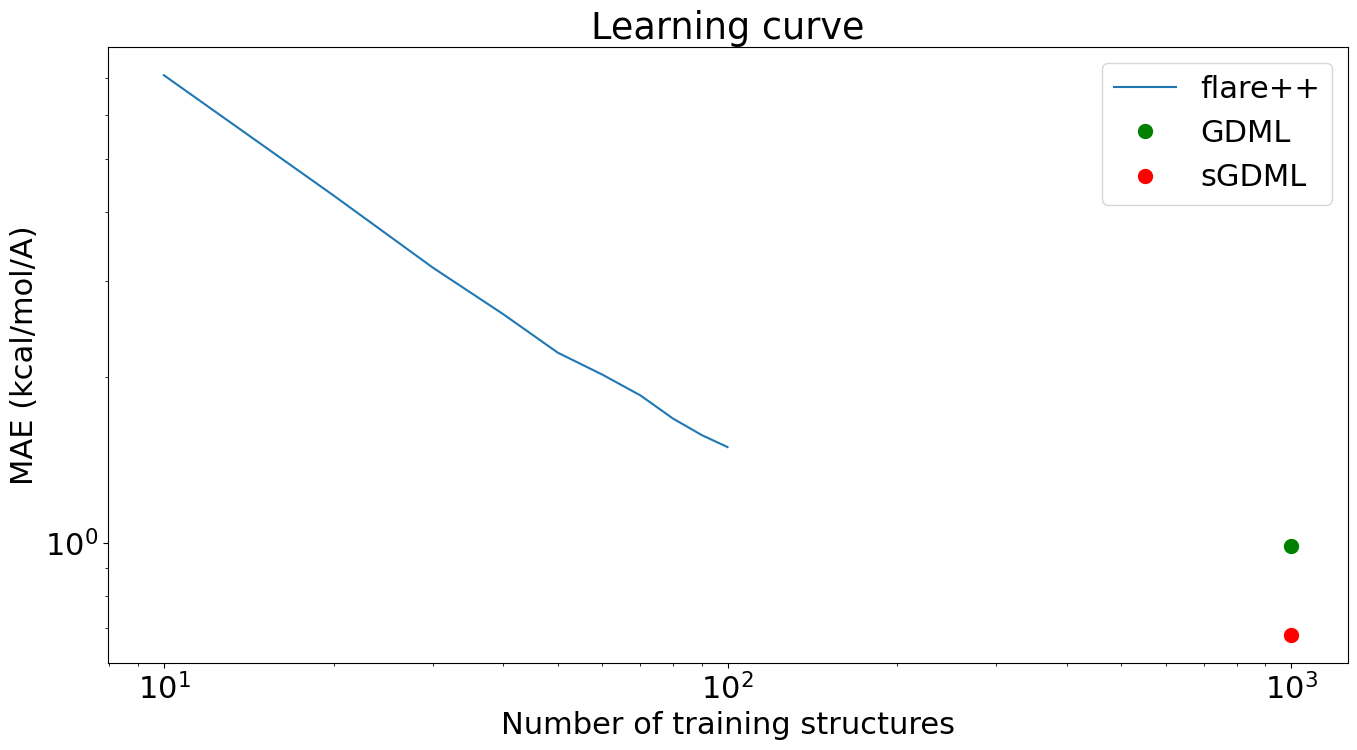

In [28]:
# Plot the learning curve.
plt.figure(figsize=(16, 8))
plt.loglog(n_strucs, mb_maes, label="flare++")
plt.loglog(1000, 0.0429 * 23, 'g.', markersize=20, label="GDML")
plt.loglog(1000, 0.0295 * 23, 'r.', markersize=20, label="sGDML")
plt.title("Learning curve")
plt.xlabel("Number of training structures")
plt.ylabel("MAE (kcal/mol/A)")
plt.legend()
plt.show()

### Mapping the trained model

We can map the trained sparse GP onto a fast quadratic model implemented in lammps with the following lines:

In [29]:
# Write lammps potential file.
file_name = "aspirin.txt"
contributor = "Your Name Here"

# The "kernel index" indicates which kernel to map for multi-descriptor models.
# For single-descriptor models like this one, just set it to 0.
kernel_index = 0

gp_model.write_mapping_coefficients(file_name, contributor, kernel_index)

If you click on the Files tab on the left hand side of the screen, you'll see the lammps potential file that we just wrote. This can be used to perform efficient MD simulations in lammps using the custom "flare" pairstyle.

## Learning a many-body force field on the fly

We're now ready to train a force field on the fly. In real applications, you would want to use a DFT code or some other quantum solver to compute reference energies and forces, but here for simplicity our goal will be to re-construct a many-body EAM potential on the fly.

In [30]:
# Download an aluminum EAM potential from the NIST potential database.
! wget https://www.ctcms.nist.gov/potentials/Download/1999--Mishin-Y-Farkas-D-Mehl-M-J-Papaconstantopoulos-D-A--Al/2/Al99.eam.alloy

--2024-09-15 10:47:17--  https://www.ctcms.nist.gov/potentials/Download/1999--Mishin-Y-Farkas-D-Mehl-M-J-Papaconstantopoulos-D-A--Al/2/Al99.eam.alloy
Resolving www.ctcms.nist.gov (www.ctcms.nist.gov)... 129.6.13.19
Connecting to www.ctcms.nist.gov (www.ctcms.nist.gov)|129.6.13.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 780452 (762K)
Saving to: ‘Al99.eam.alloy’

Al99.eam.alloy      100%[===================>] 762.16K  --.-KB/s    in 0.09s   

2024-09-15 10:47:17 (8.60 MB/s) - ‘Al99.eam.alloy’ saved [780452/780452]



In [31]:
# Define modified EAM calculator with null stress.
from ase.calculators.calculator import all_changes
class EAM_mod(EAM):
  implemented_properties = ["energy", "forces", "stress", "stresses"]
  def calculate(self, atoms=None, properties=['energy'],
                system_changes=all_changes):
    super().calculate(atoms, properties, system_changes)
    self.results['stress'] = np.zeros(6)
    self.results['stresses'] = np.zeros(6)

In [32]:
# Define ASE calculator.
eam_potential = EAM_mod(potential="Al99.eam.alloy")

To train a sparse GP on the fly, we follow four basic steps.

### Step 1: Choose the initial structure.

We'll simulate an adatom on an aluminum slab to illustrate what happens when one local environment doesn't resemble any of the others in the structure.

In [48]:
# Create a slab with an adatom.
atoms = fcc111("Al", (4, 4, 6), vacuum=10.0)
add_adsorbate(atoms, "Al", 2.5, "ontop")
n_atoms = len(atoms)

# Randomly jitter the atoms to give nonzero forces in the first frame.
jitter_factor = 0.1
for atom_pos in atoms.positions:
    for coord in range(3):
        atom_pos[coord] += (2 * random() - 1) * jitter_factor

view(atoms, viewer='x3d')

### Step 2: Choose molecular dynamics settings.

We'll set the initial temperature to 200 K and simulate in the NVE ensemble. In many applications, it's useful to add thermostats and barostats to control temperature and pressure.

In [59]:
# Set MD parameters.
md_engine = "VelocityVerlet"
md_dict = {}

# Set the initial velocity to 300 K.
temperature = 300  # in K
MaxwellBoltzmannDistribution(atoms, temperature_K=temperature)
Stationary(atoms)  # zero linear momentum
ZeroRotation(atoms)  # zero angular momentum

### Step 3: Choose model settings.

In addition to the quantities we encountered earlier (cutoff, basis set, and noise values), we'll also choose the type of uncertainties we want to compute and choose settings for hyperparameter optimization.

In [97]:
# Create sparse GP model.
species_map = {13: 0}  # Aluminum (atomic number 13) is species 0
cutoff = 5.0  # in A
sigma = 2.0  # in eV
power = 2  # power of the dot product kernel
kernel = NormalizedDotProduct(sigma, power)
cutoff_function = "quadratic"
many_body_cutoffs = [cutoff]
radial_basis = "chebyshev"
radial_hyps = [0., cutoff]
cutoff_hyps = []
n_species = 1
N = 8
lmax = 3
descriptor_settings = [n_species, N, lmax]
descriptor_calculator = B2(
  radial_basis,
  cutoff_function,
  radial_hyps,
  cutoff_hyps,
  descriptor_settings
)

# Set the noise values.
sigma_e = 0.001 * n_atoms  # eV (1 meV/atom)
sigma_f = 0.05  # eV/A
sigma_s = 0.0006  # eV/A^3 (about 0.1 GPa)

# Choose uncertainty type.
# Other options are "DTC" (Deterministic Training Conditional) or
# "SOR" (Subset of Regressors).
variance_type = "local"  # Compute uncertainties on local energies (normalized)

# Choose settings for hyperparameter optimization.
max_iterations = 20  # Max number of BFGS iterations during optimization
opt_method = "L-BFGS-B"  # Method used for hyperparameter optimization

# Bounds for hyperparameter optimization.
# Keeps the energy noise from going to zero.
bounds = [(None, None), (sigma_e, None), (None, None), (None, None)]

# Create a model wrapper that is compatible with the flare code.
gp_model = SGP_Wrapper(
    [kernel],
    [descriptor_calculator],
    cutoff,
    sigma_e,
    sigma_f,
    sigma_s,
    species_map,
    variance_type=variance_type,
    stress_training=False,
    opt_method=opt_method,
    bounds=bounds,
    max_iterations=max_iterations,
)

# Create an ASE calculator based on the GP model.
flare_calculator = SGP_Calculator(gp_model)

### Step 4: Choose on-the-fly settings.

There are two important choices to make here:
  

*   The uncertainty tolerance (defined as `std_tolerance_factor` below) determines when calls to DFT are made. Because we are computing normalized uncertainties on local energies, a reasonable value is around 1%. A higher value will trigger fewer DFT calls but may reduce the accuracy of the model, so in practice it's a good idea to try out a few different values. Note that a positive `std_tolerance_factor` defines the tolerance as a fraction of the noise parameter, while a negative value defines it in absolute terms.
*   `update_style` specifies the strategy for adding sparse environments to the GP. Here we set it to the `threshold` style, which only adds sparse environments if their associated uncertainty is above the defined `update_threshold`. This helps eliminate redundancy from the sparse set.

In [98]:
# Set up OTF object.
init_atoms = list(range(n_atoms))  # Initial environments to include in the sparse set
output_name = 'Al'  # Name of the output file
std_tolerance_factor = -0.01  # Uncertainty tolerance for calling QM
train_hyps = (0, 2)  # Freeze hyperparameter optimization after second QM call
min_steps_with_model = 10  # Min number of steps between DFT calls
update_style = "threshold"  # Strategy for adding sparse environments
update_threshold = 0.005  # Threshold for determining which sparse environments to add
force_only = False  # Train only on forces or include energies and stresses

otf_params = {
    'init_atoms': init_atoms,
    'output_name': output_name,
    'std_tolerance_factor': std_tolerance_factor,
    'train_hyps': train_hyps,
    'min_steps_with_model': min_steps_with_model,
    'update_style': update_style,
    'update_threshold': update_threshold,
}

# Create OTF object.
timestep = 0.001  # units of ps
number_of_steps = 500
test_otf = OTF(
    atoms,
    timestep,
    number_of_steps,
    eam_potential,
    md_engine,
    md_dict,
    flare_calc=flare_calculator,
    force_only=force_only,
    **otf_params,
)

# Run on-the-fly dynamics.
test_otf.run()

Precomputing KnK for hyps optimization
Done precomputing. Time: 0.0012540817260742188
Hyperparameters:
[2.0e+00 9.7e-02 5.0e-02 6.0e-04]
Likelihood gradient:
[ 7.05841547e-01 -3.18601361e+00 -4.57660643e+03  0.00000000e+00]
Likelihood:
494.9480193789421


Hyperparameters:
[ 2.00015423e+00  9.70000000e-02 -9.49999988e-01  6.00000000e-04]
Likelihood gradient:
[  6.52839399 -19.20677282 294.52571974   0.        ]
Likelihood:
-273.3654487317382


Hyperparameters:
[ 2.00003954e+00  9.70000000e-02 -2.06361137e-01  6.00000000e-04]
Likelihood gradient:
[   1.69273383  -19.44356747 1275.19012926    0.        ]
Likelihood:
142.86681228647507


Hyperparameters:
[ 2.00000914e+00  9.70000000e-02 -9.24677412e-03  6.00000000e-04]
Likelihood gradient:
[  13.20272105   11.63467619 -863.21368959    0.        ]
Likelihood:
761.8429596348944


Hyperparameters:
[ 2.00026825e+00  9.72405914e-02 -2.30211186e-02  6.00000000e-04]
Likelihood gradient:
[4.75195265e+00 1.69096654e+01 8.07249808e+03 0.00000000e+00

### Analyzing the simulation

In [99]:
# Parse the output file.
output_file = 'Al.out'
otf_trajectory = otf_parser.OtfAnalysis(output_file)

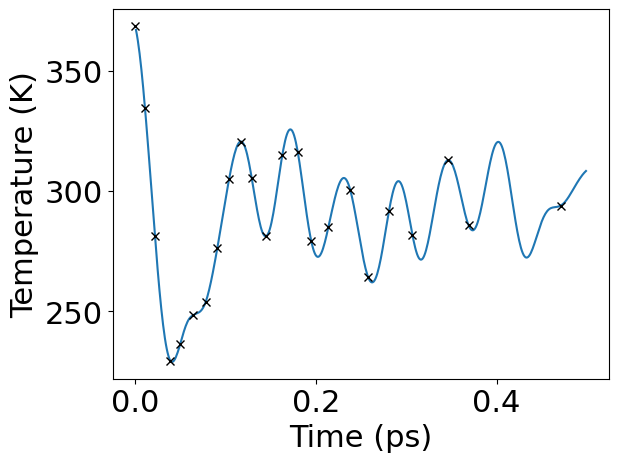

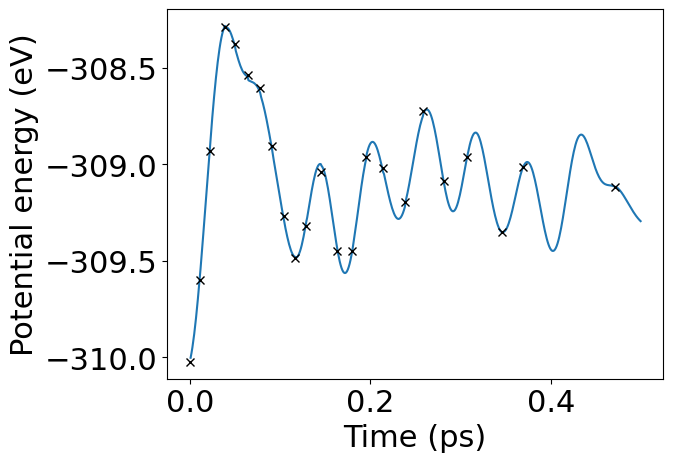

In [100]:
# Plot temperature and energy vs. simulation time.
times = otf_trajectory.times
eam_times = otf_trajectory.dft_times

temps = otf_trajectory.thermostat['temperature']
eam_temps = otf_trajectory.gp_thermostat['temperature']

gp_energies = otf_trajectory.thermostat['potential energy']
eam_energies = otf_trajectory.gp_thermostat['potential energy']

plt.plot(times, temps)
plt.plot(eam_times, eam_temps, 'kx')
plt.xlabel('Time (ps)')
plt.ylabel('Temperature (K)')
plt.show()

plt.plot(times, gp_energies)
plt.plot(eam_times, eam_energies, 'kx')
plt.xlabel("Time (ps)")
plt.ylabel("Potential energy (eV)")
plt.show()

In [101]:
# Write xyz file to visualize the simulation.
position_list = np.array(otf_trajectory.position_list)
cells = np.array(otf_trajectory.cell_list)
uncertainties = np.array(otf_trajectory.uncertainty_list)

# Create list of atoms objects.
atom_list = []
spec = otf_trajectory.gp_species_list[0]
skip = 1
for n in np.arange(0, len(position_list), skip):
    atoms_curr = Atoms(
        spec,
        positions=position_list[n],
        cell=cells[n],
        momenta=uncertainties[n],
        pbc=True)
    atom_list.append(atoms_curr)

# Dump atoms.
write('Al.xyz', atom_list, format='extxyz')

In [102]:
# Write lammps potential file.
file_name = "aluminum.txt"
contributor = "Your Name Here"
kernel_index = 0
gp_model.sparse_gp.write_mapping_coefficients(file_name, contributor, kernel_index)

<img src="https://github.com/mir-group/APS-2020-FLARE-Tutorial/blob/master/APS-2020/al.gif?raw=true" width="100%">

<img src="https://github.com/mir-group/APS-2020-FLARE-Tutorial/blob/master/APS-2020/conclusion3.png?raw=true" width="100%">